In [12]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture as GMM
from scipy.stats import norm
from scipy.sparse import save_npz
import random

In [13]:
df = pd.read_csv('/data/edgelist.csv')
G = nx.from_pandas_edgelist(df, edge_attr=True)

In [14]:
random.seed(0)

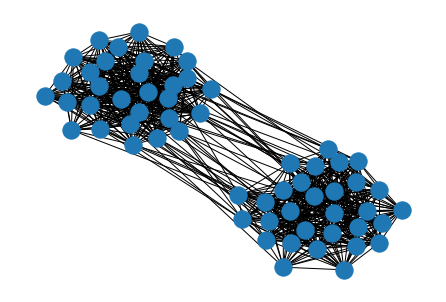

In [15]:
pos = nx.spring_layout(G, seed = 0)
nx.draw(G, pos)

In [16]:
df

,source,target,ricciCurvature,group,weight,low,bfcsecond
0,0,2,0.325099,0,1.0,0.031621,0.085066
1,0,3,0.366162,0,1.0,0.316498,0.067215
2,0,5,0.337273,0,1.0,0.052727,0.075200
3,0,7,0.322727,0,1.0,0.052727,0.075200
4,0,10,0.389328,0,1.0,0.428854,0.085066
...,...,...,...,...,...,...,...
727,56,58,0.375562,0,1.0,0.404798,0.061831
728,56,59,0.368577,0,1.0,0.164032,0.085066
729,57,58,0.354885,0,1.0,0.254310,0.063020
730,57,59,0.350379,0,1.0,0.106061,0.079861


In [17]:
lowdf = df["low"]

In [18]:
lowdf

0      0.031621
1      0.316498
2      0.052727
3      0.052727
4      0.428854
         ...   
727    0.404798
728    0.164032
729    0.254310
730    0.106061
731    0.105016
Name: low, Length: 732, dtype: float64

middle point:
-0.8899999999999995
probability of the middle point:
1.0966157967558068e-06


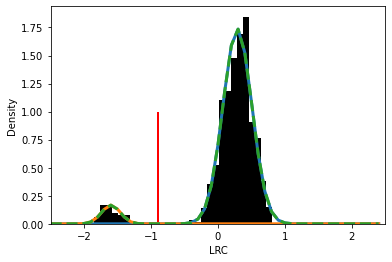

<Figure size 432x288 with 0 Axes>

In [19]:
### HISTOGRAM & GMM & FIND ALPHA ###
# create GMM model object with two components
x = np.ravel(lowdf).astype(float)
x = x.reshape(-1, 1)
gmm2 = GMM(n_components = 2, max_iter=1000, random_state=10, covariance_type = 'full')

# find useful parameters
mean2 = gmm2.fit(x).means_
covs2  = gmm2.fit(x).covariances_
weights2 = gmm2.fit(x).weights_

# find the middle point
p = 100 #the probability of x
x_val = -3

sgmm = min(mean2[0][0], mean2[1][0])
bgmm = max(mean2[0][0], mean2[1][0])

for i in np.arange(round(float(sgmm), 2), round(float(bgmm),2)+0.01, 0.01):
    y_0 = norm.pdf(i, float(mean2[0][0]), np.sqrt(float(covs2[0][0][0])))*weights2[0] # 1st gaussian
    y_1 = norm.pdf(i, float(mean2[1][0]), np.sqrt(float(covs2[1][0][0])))*weights2[1] # 2nd gaussian
    p_new = y_0 + y_1
    if p > p_new:
        p = p_new
        x_val = i
    else:
        continue
print("middle point:")
print(x_val)
print("probability of the middle point:")
print(p)

# create necessary things to plot
x_axis = np.arange(-2.5, 2.5, 0.1)
y_axis0 = norm.pdf(x_axis, float(mean2[0][0]), np.sqrt(float(covs2[0][0][0])))*weights2[0] # 1st gaussian
y_axis1 = norm.pdf(x_axis, float(mean2[1][0]), np.sqrt(float(covs2[1][0][0])))*weights2[1] # 2nd gaussian

# Plot histogram with GMM
plt.hist(x, density=True, color='black', bins=30)
plt.plot(x_axis, y_axis0, lw=3, color = "C0")
plt.plot(x_axis, y_axis1, lw=3, color = "C1")
plt.plot(x_axis, y_axis0+y_axis1, lw=3, c="C2", ls='dashed')
plt.xlim(-2.5, 2.5)
#plt.ylim(0.0, 2.0)
plt.xlabel(r"LRC", fontsize=10)
plt.ylabel(r"Density", fontsize=10)
# Draw alpha in the plot
plt.vlines(x=x_val, ymin=0, ymax=1, colors='red', ls='solid', lw=2, label='$\beta$')
plt.show()
plt.savefig('gausmix_2compo.pdf', bbox_inches='tight')
plt.clf()

In [20]:
def remove_curv(k, G, name):
    ebunch = []
    for e in G.edges(data=True):
        if e[2][name] < k:
            ebunch.append((e[0], e[1]))
    G.remove_edges_from(ebunch)


'/work/users/y/j/yjinpark/final_figures/figure/workflow/workflow.pdf'

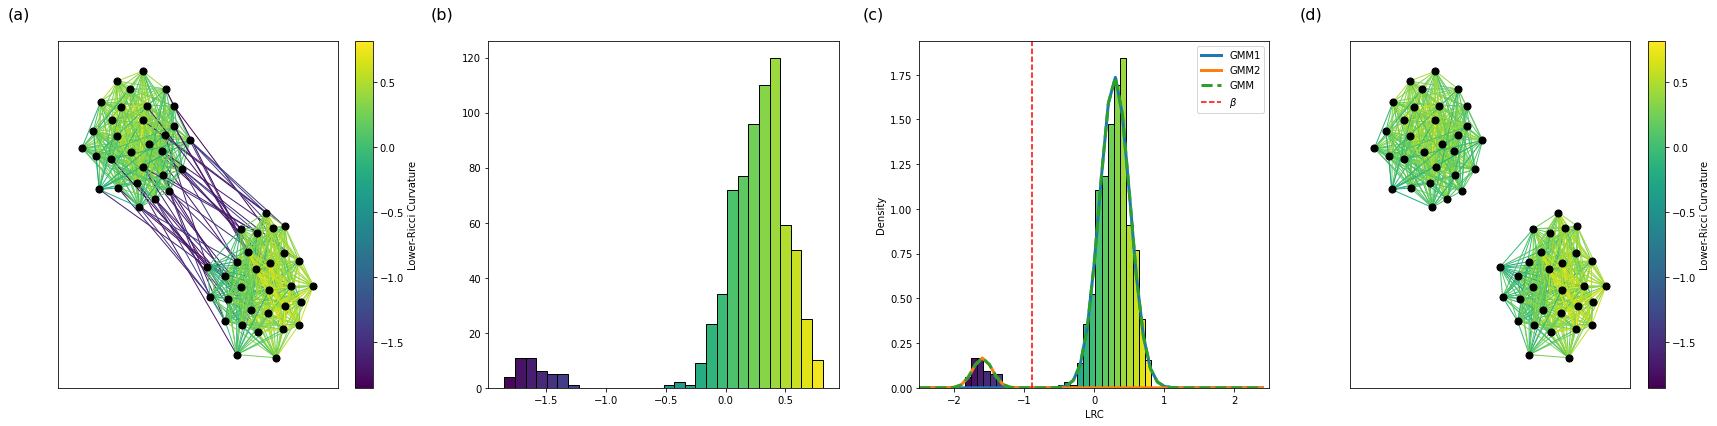

In [21]:
# Choose a colormap
cmap = plt.cm.viridis
edge_values = {(i,j): G[i][j]["low"] for i, j in G.edges()} 

# Manually set the range for your colormap
vmin = min(edge_values.values())
vmax = max(edge_values.values())

edge_valuesb = {(i,j): G[i][j]["bfcsecond"] for i, j in G.edges()} 
vminb = min(edge_valuesb.values())
vmaxb = max(edge_valuesb.values())

fig = plt.figure(figsize=(24, 6))
node_size = 50
fixed_positions = nx.spring_layout(G, seed=0)

initial_edge_colors = {e: cmap((edge_values[e] - vmin) / (vmax - vmin)) for e in G.edges()}

# Draw the graph
ax1 = fig.add_subplot(1, 4, 1)
pos = nx.spring_layout(G, seed = 0)
ec = nx.draw_networkx_edges(G, fixed_positions, edge_color=[initial_edge_colors[e] for e in G.edges() if e in initial_edge_colors])
nc = nx.draw_networkx_nodes(G, fixed_positions, node_color='black', node_size=node_size)
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin, vmax), cmap=cmap), ax=ax1, orientation='vertical')
cbar.set_label('Lower-Ricci Curvature')

ax1.text(-0.1, 1.1, '(a)', transform=ax1.transAxes, fontsize=16, va='top', ha='right')

# Draw the histogram
ax2 = fig.add_subplot(1, 4, 2)
n, bins, patches = plt.hist(edge_values.values(), bins=30, edgecolor = "black")
bin_centers = 0.5 * (bins[:-1] + bins[1:])
for c, p in zip(bin_centers, patches):
    plt.setp(p, 'facecolor', cmap((c - vmin) / (vmax - vmin)))

ax2.text(-0.1, 1.1, '(b)', transform=ax2.transAxes, fontsize=16, va='top', ha='right')


ax3 = fig.add_subplot(1, 4, 3)
n, bins, patches = plt.hist(edge_values.values(), bins=30, edgecolor = "black", density = True)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
for c, p in zip(bin_centers, patches):
    plt.setp(p, 'facecolor', cmap((c - vmin) / (vmax - vmin)))
plt.plot(x_axis, y_axis0, lw=3, color = "C0", label = "GMM1")
plt.plot(x_axis, y_axis1, lw=3, color = "C1", label = "GMM2")
plt.plot(x_axis, y_axis0+y_axis1, lw=3, c="C2", ls='dashed', label = "GMM")
plt.xlim(-2.5, 2.5)
#plt.ylim(0.0, 2.0)
plt.xlabel(r"LRC", fontsize=10)
plt.ylabel(r"Density", fontsize=10)
# Draw alpha in the plot
plt.axvline(x=x_val, color='red', linestyle='--', label=r'$\beta$')
plt.legend(loc='upper right')

ax3.text(-0.1, 1.1, '(c)', transform=ax3.transAxes, fontsize=16, va='top', ha='right')

remove_curv(x_val, G, "low")
ax4 = fig.add_subplot(1, 4, 4)
pos = nx.spring_layout(G, seed = 0)
ec = nx.draw_networkx_edges(G, fixed_positions, edge_color=[initial_edge_colors[e] for e in G.edges() if e in initial_edge_colors])
nc = nx.draw_networkx_nodes(G, fixed_positions, node_color='black', node_size=node_size)
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin, vmax), cmap=cmap), ax=ax4, orientation='vertical')
cbar.set_label('Lower-Ricci Curvature')
ax4.text(-0.1, 1.1, '(d)', transform=ax4.transAxes, fontsize=16, va='top', ha='right')
plt.tight_layout()

# Save the figure
file_path = 'workflow.pdf'
fig.savefig(file_path)

file_path